In [1]:
import numpy as np
import json
import pandas as pd
from pathlib import Path
from skimage import measure
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

In [2]:
root_path = Path('data')
img_path = Path('/home/iref/PycharmProjects/CSA_new_pipeline/core-sample-snakemake/data/raw/photos/')

In [102]:
raw_df = pd.read_csv(root_path / 'raw/segmented_data.csv' )
raw_df = raw_df[raw_df['user'].isin(['markup_expert01', 'markup_expert02'])]
ruin = set(raw_df[raw_df['segment_type'] == 'Разрушенность']['photo_id'].values)
print(f'Число фотографий, на которых есть "разрушенные" сегменты: {len(ruin)}')
core = set(raw_df[raw_df['segment_type'] == 'Порода']['photo_id'].values)
print(f'Число фотографий, на которых отмечены породы: {len(core)}')
inter = ruin.intersection(core)
inter = np.array(list(inter))
print(f'Пересечение: {len(inter)}')
random_sample = np.random.choice(np.array(inter))
print(f'Случайный сэмпл: {random_sample}')
raw_df[raw_df['photo_id']==random_sample]

Число фотографий, на которых есть "разрушенные" сегменты: 571
Число фотографий, на которых отмечены породы: 785
Пересечение: 571
Случайный сэмпл: 1003332


,user,task_id,photo_id,photo_type,segment_num,segment_type,segment_value
27071,markup_expert01,24fab7d1_0a88_4755_bc1c_469c929e0175,1003332,ДС,0,Разрушенность,Разлом
27072,markup_expert01,24fab7d1_0a88_4755_bc1c_469c929e0175,1003332,ДС,1,Порода,Песчаник
27073,markup_expert01,24fab7d1_0a88_4755_bc1c_469c929e0175,1003332,ДС,2,Порода,Песчаник


In [43]:
cleared = raw_df[raw_df['photo_id'].isin(inter)]
print(cleared['segment_type'].value_counts(), '\n')

print(cleared['segment_value'].value_counts())

Порода           9932
Разрушенность    8162
Name: segment_type, dtype: int64 

Разлом                        7871
Песчаник                      3381
Переслаивание пород           3327
Алевролит                     1538
Алевролит глинистый            733
Аргиллит                       389
Песчаник глинистый             366
Проба                          291
Карбонатная порода              40
Уголь                           40
Аргиллит углистый               32
Глина аргиллитоподобная         27
Известняк                       15
Глина                           15
Кремнисто-глинистая порода      10
Брекчия                          5
Песок                            4
Кремнистая порода                4
Алеврит                          4
Глинисто-кремнистая порода       1
Доломит                          1
Name: segment_value, dtype: int64


In [27]:
def prepare_data(labels_path=root_path / 'raw/matrixes', 
                 images_path = img_path, 
                 data_path = root_path / 'raw/segmented_data.csv',
                 experts_only = True):
    data = pd.read_csv(data_path)
    white_list = ['Песчаник', 'Алевролит', 'Аргиллит', 'Переслаивание пород']
    data = data[data['segment_value'].isin(white_list) & (data['photo_type'] == 'ДС') 
                & (data['segment_type'] == 'Порода')]
    data = data[['photo_id','task_id','user','segment_num','segment_value']]
    if experts_only:
        users_list = ['markup_expert01', 'markup_expert02']
        data = data[data['user'].isin(users_list)]
    photo_ids = list(set(data['photo_id']))
    return data

In [28]:
main_df = prepare_data()
main_df.to_csv(root_path / 'cleared.csv', index=False)
main_df = pd.read_csv(root_path / 'cleared.csv')
main_df
# print(main_df['photo_id'].value_counts())
# main_df_clear = main_df[main_df['segment_value']!='Переслаивание пород']
# main_df_clear['photo_id'].value_counts()

,photo_id,task_id,user,segment_num,segment_value
0,1008462,107a6c34_19e2_4bd6_a4b7_7f0251bb2ea0,markup_expert01,0,Переслаивание пород
1,1008462,107a6c34_19e2_4bd6_a4b7_7f0251bb2ea0,markup_expert01,1,Песчаник
2,1003336,10f0518a_5f16_408d_9fb7_7750a98f3a0c,markup_expert01,0,Песчаник
3,1002244,20c900c8_a082_4a92_99c4_2da482f6b8c7,markup_expert01,0,Переслаивание пород
4,1011830,217b97ba_da61_4eb9_a45c_2f7f0932f22b,markup_expert01,1,Песчаник
...,...,...,...,...,...
2140,1000072,69adcb70_0c67_46c3_9117_923fd94c00c8,markup_expert02,10,Алевролит
2141,1000072,69adcb70_0c67_46c3_9117_923fd94c00c8,markup_expert02,11,Песчаник
2142,1000072,69adcb70_0c67_46c3_9117_923fd94c00c8,markup_expert02,12,Песчаник
2143,1010492,6aeb738a_37ec_431f_bef5_0b416a519ab2,markup_expert02,0,Песчаник


In [124]:
segments_to_labels = {
    'Аргиллит': 0,
    'Алевролит': 1,
    'Песчаник': 2,
    'Переслаивание пород': 3
}

photos = main_df['photo_id'].unique()
for p_id in photos:
    temp_df = main_df[main_df['photo_id']==p_id]
    task_id = temp_df['task_id'].values[0]
    file_name = f'matrix_{p_id}__{task_id}.npz'
    matrix = np.load(root_path/'raw/matrixes'/file_name)['data']
    
    for index, row in temp_df.iterrows():
        seg_num = row['segment_num']
        seg_val = row['segment_value']
        res = np.where(matrix == seg_num, segments_to_labels[seg_val], matrix)
        np.savez_compressed(root_path/'interim/converted_matrixes'/file_name, res)

In [105]:
test = Image.open(root_path / 'Dataset/Images/1003332.jpeg')
converted_test = np.load(root_path/'Dataset/Masks/matrix_1003332__24fab7d1_0a88_4755_bc1c_469c929e0175.npz')

In [106]:
np.unique(converted_test['arr_0'])

array([0, 1])

In [107]:
converted_test['arr_0']

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

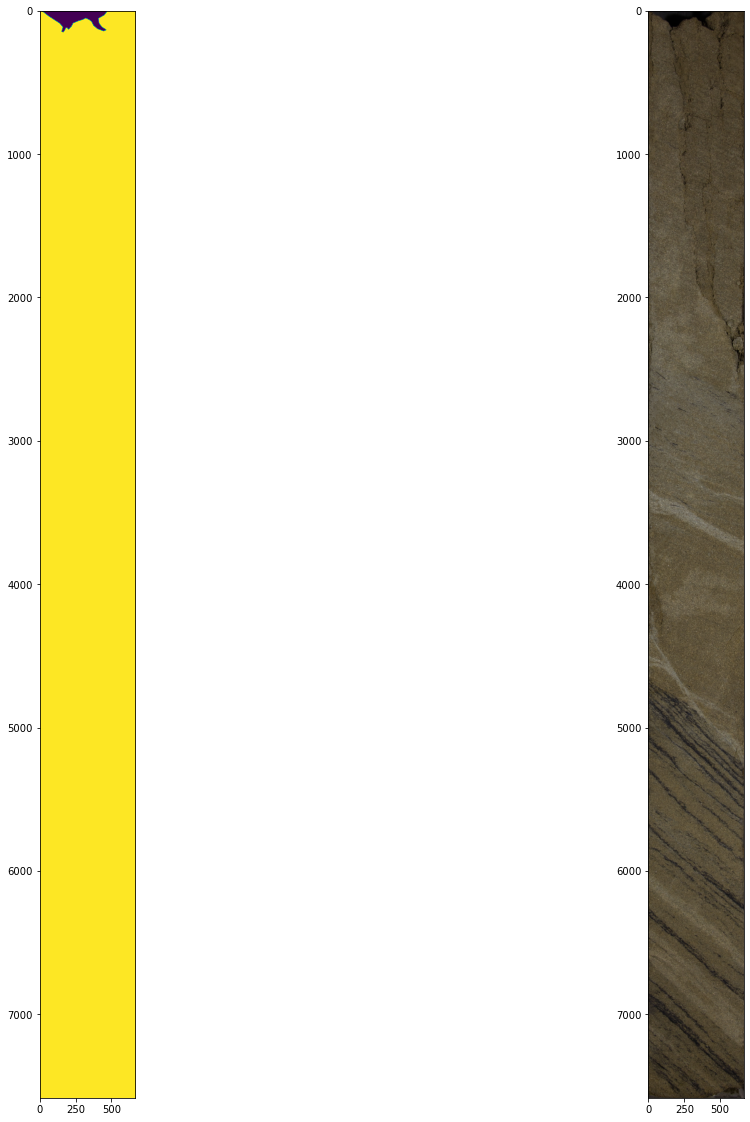

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
ax1.imshow(converted_test['arr_0'])
ax2.imshow(test)

In [4]:
from data_extraction import SegDataset, ToTensor, Normalize, Resize

In [9]:
data_transforms = {
    'Train': transforms.Compose([Resize(imageresize=(512, 512), maskresize=(512, 512)),ToTensor(), Normalize()]),
    'Test': transforms.Compose([Resize(imageresize=(512, 512), maskresize=(512, 512)), ToTensor(), Normalize()]),
}

In [10]:
test_ds = SegDataset(root_path / 'Dataset', imageFolder='Images', maskFolder='Masks',seed=100, fraction=0.2, subset='Train', transform=data_transforms['Train'])

In [11]:
[(test_ds[5][x].shape, test_ds[5][x].shape) for x in ['image', 'mask']]

[(torch.Size([3, 512, 512]), torch.Size([3, 512, 512])),
 (torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))]

In [12]:
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=1)

In [ ]:
it = iter(test_dl)
next(it)